In [1]:
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import timm
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import os
from glob import glob 
import numpy as np
import json
from collections import OrderedDict

import cv2 
from PIL import Image

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def get_annotation(mode='train'):
    anns = OrderedDict()
    annotation_path = f'/data/datasets/jsons/{mode}.json'
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)

        for filename in annotations['images'].keys():
            if 'words' in annotations['images'][filename]:
                # Words의 Points 변환
                gt_words = annotations['images'][filename]['words']
                polygons = [np.array([np.round(word_data['points'])], dtype=np.int32)
                            for word_data in gt_words.values()
                            if len(word_data['points'])]
                anns[filename] = polygons
    return anns

In [4]:
def get_data(anns, mode='train'):
    data = OrderedDict()
    if mode == 'train':
        image_path = '/data/datasets/images/train/'
    elif mode == 'val':
        image_path = '/data/datasets/images/val/'
    for idx in range(len(anns)):
        image_filename = list(anns.keys())[idx]
        image_file_path = os.path.join(image_path, image_filename)
        image = cv2.imread(image_file_path)

        polygons = anns[image_filename]

        min_x, min_y = min(p[0][0][0] for p in polygons), min(p[0][0][1] for p in polygons)
        max_x, max_y = max(p[0][2][0] for p in polygons), max(p[0][2][1] for p in polygons)

        h, w, c = image.shape

        crop_w, crop_h = max_x - min_x, max_y - min_y

        new_min_x = 0 if min_x - ((w - crop_w) / 10) < 0 else min_x - ((w - crop_w) / 10) 
        new_max_x = w if max_x + ((w - crop_w) / 10) > w else max_x + ((w - crop_w) / 10)

        new_min_y = 0 if min_y - ((h - crop_h) / 4) < 0 else min_y - ((h - crop_h) / 4) 
        new_max_y = h if max_y + ((h - crop_h) / 4) > h else max_y + ((h - crop_h) / 4)

        new_min_x, new_min_y, new_max_x, new_max_y = int(new_min_x), int(new_min_y), int(new_max_x), int(new_max_y)
        data[image_file_path] = [new_min_x, new_min_y, new_max_x, new_max_y]
    return data 


In [5]:
train_anns = get_annotation(mode='train')
val_anns = get_annotation(mode='val')

In [6]:
train_data = get_data(train_anns, mode='train')
val_data = get_data(val_anns, mode='val')

In [7]:
train_data.update(val_data)

In [8]:
total_data = train_data.copy()

In [7]:
from torch.utils.data import Dataset

class CropDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data 
        self.transforms = transforms
        self.EXIF_ORIENTATION = 274
        self.image_size = 640

    def __len__(self):
        return len(self.data.keys())
    
    def __getitem__(self, index):
        image_file_path = list(self.data.keys())[index]
        image = Image.open(image_file_path).convert('RGB')

        exif = image.getexif()
        if exif:
            if self.EXIF_ORIENTATION in exif:
                image = CropDataset.rotate_image(image, exif[self.EXIF_ORIENTATION])
        
        image = np.array(image)
        if self.data[image_file_path]:
            min_x, min_y, max_x, max_y = self.data[image_file_path]

            h, w, c = image.shape

            ratio_x = self.image_size / w
            ratio_y = self.image_size / h

            new_min_x = ratio_x * min_x
            new_min_y = ratio_y * min_y
            new_max_x = ratio_x * max_x
            new_max_y = ratio_y * max_y

            transformed_image = self.transforms(image=image)['image']
            item = OrderedDict(image=transformed_image, bbox=torch.tensor([new_min_x, new_min_y, new_max_x, new_max_y]))
            return item
        else:
            transformed_image = self.transforms(image=image)['image']
            return OrderedDict(image=transformed_image)
        
    @staticmethod
    def rotate_image(image, orientation):
        if orientation == 2:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            image = image.rotate(180)
        elif orientation == 4:
            image = image.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            image = image.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            image = image.rotate(-90, expand=True)
        elif orientation == 7:
            image = image.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            image = image.rotate(90, expand=True)
        return image

transforms = A.Compose([
    A.Resize(640, 640),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])



In [10]:
dataset = CropDataset(total_data, transforms)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [4]:
class DetectModel(nn.Module):
    def __init__(self):
        super(DetectModel, self).__init__()

        self.resnet = timm.create_model('resnet50', pretrained=True)
        self.fc = nn.Linear(in_features=self.resnet.fc.out_features, out_features=4)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [12]:
model = DetectModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
criterion = torch.nn.MSELoss()

losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for idx, (batch) in enumerate(train_loader):
        images = batch['image'].to(device)
        bbox = batch['bbox'].float().to(device)

        # Forward pass 및 Loss 계산
        pred = model(images)

        loss = criterion(pred, bbox)

        # Backward pass 및 Optimizer 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx + 1) % 46 == 0:
            print(f'[{idx + 1}/{len(train_loader)}] Loss : {loss.item()}')
            losses.append(loss.item())


model.safetensors: 100%|██████████| 102M/102M [00:00<00:00, 108MB/s] 


Epoch [1/50]
[46/230] Loss : 1901.006591796875
[92/230] Loss : 1013.044677734375
[138/230] Loss : 941.58837890625
[184/230] Loss : 656.3167724609375
[230/230] Loss : 421.52899169921875
Epoch [2/50]
[46/230] Loss : 436.542724609375
[92/230] Loss : 633.6092529296875
[138/230] Loss : 734.6862182617188
[184/230] Loss : 688.8059692382812
[230/230] Loss : 374.17120361328125
Epoch [3/50]
[46/230] Loss : 309.46759033203125
[92/230] Loss : 517.1339111328125
[138/230] Loss : 625.451416015625
[184/230] Loss : 253.91448974609375
[230/230] Loss : 744.1344604492188
Epoch [4/50]
[46/230] Loss : 345.36578369140625
[92/230] Loss : 332.6240234375
[138/230] Loss : 223.20745849609375
[184/230] Loss : 392.6764221191406
[230/230] Loss : 232.11326599121094
Epoch [5/50]
[46/230] Loss : 153.36004638671875
[92/230] Loss : 254.33978271484375
[138/230] Loss : 264.3731689453125
[184/230] Loss : 133.5159912109375
[230/230] Loss : 681.029052734375
Epoch [6/50]
[46/230] Loss : 86.06924438476562
[92/230] Loss : 260.79

In [13]:
torch.save(model, "detect_reciept_model50.ckpt")

In [5]:
best_model = torch.load('/data/ephemeral/home/baseline_code/detect_reciept_model34.ckpt')

In [6]:
test_data_path = glob('/data/datasets/images/test/*.jpg')

data = OrderedDict()
for data_path in test_data_path:
    data[data_path] = None

In [8]:
test_dataset = CropDataset(data, transforms)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [9]:
preds = []
with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        images = batch['image'].to(device)

        pred = best_model(images)
        preds.extend(pred.detach().cpu().numpy().tolist())


100%|██████████| 104/104 [00:02<00:00, 35.38it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


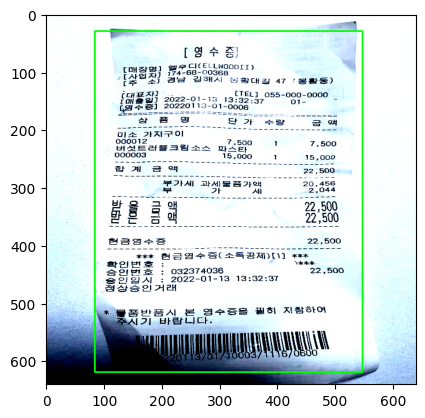

In [10]:
import matplotlib.pyplot as plt 

idx = 5
image = test_dataset[idx]['image']
transformed_image = torch.permute(image, (1, 2, 0)).detach().cpu().numpy()
x_min, y_min, x_max, y_max = preds[idx]
cv2.rectangle(transformed_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
plt.imshow(transformed_image)

In [11]:
bbox_preds = OrderedDict()

In [12]:
for path, bbox in zip(test_data_path, preds):
    new_min_x, new_min_y, new_max_x, new_max_y = bbox
    h, w, c = cv2.imread(path).shape

    ratio_x = 640 / w
    ratio_y = 640 / h

    origin_min_x = int(new_min_x / ratio_x)
    origin_min_y = int(new_min_y / ratio_y)
    origin_max_x = int(new_max_x / ratio_x)
    origin_max_y = int(new_max_y / ratio_y)

    bbox_preds[path.split('/')[-1]] = [origin_min_x, origin_min_y, origin_max_x, origin_max_y]

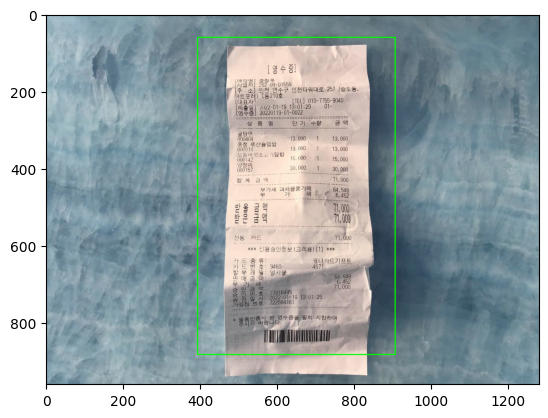

In [13]:
image_path = '/data/datasets/images/test/drp.en_ko.in_house.selectstar_003757.jpg'
# image = transforms(image=cv2.imread(image_path))['image']
image = cv2.imread(image_path)
# transformed_image = torch.permute(image, (1, 2, 0)).detach().numpy()
x_min, y_min, x_max, y_max = bbox_preds[image_path.split('/')[-1]]
cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
plt.imshow(image)

In [14]:
with open('/data/datasets/jsons/test_bbox.json', 'w') as f:
    json.dump(bbox_preds, f)